# Homework instructions


- Try to answer all questions – grading will reflect this.
- Save your answer as a **jupyter notebook** (`week_2_homework_familyName_firstName.ipynb`) or **python script** (`week_2_homework_familyName_firstName.py`)
- Submit your answers **individually** by the following **Thursday 12:00** on Brightspace.


# Question 1

The slides of the week 2 presentation file shows various pairs of survival curves and outflow curves – as seen below.

- Choose three of these six pairs, suggest a type of material or product that you think has this behavior. We saw some examples in the slides, but think of new examples!

![slide_41](../img/slide_41.png)
![slide_42](../img/slide_42.png)


**ANSWER:**

Lots of materials and products could match the various curves. The answers below are not exhaustive.

From left to right:

- The **normal distribution** could describe long-lasting products in use, but without long tails of lots of really old survivors. So it could describe washing machines and other home appliances.

- This **Weibull distribution** has a long starting period without losses, then everything’s gone in a short while. So it could describe solar panels or wind turbines that are maintained for a long period but then become obsolete and replaced in a few years.  
   **HINT**: the Weibull doesn't always look like this. Changing the parameters can make it look very different!

- The **log-normal distribution** has a short period without losses and then a long depreciation. Computers and other household electronics (ignoring the years in slide 25, just looking at the shape), and possibly some categories of cars.

- The **uniform distribution** means that a constant amount is depreciated every period. It could describe the stock of food or toilet paper or other consumables at home (over days, not years) or the stock of coal or other fossil fuel in a power station.

- The **geometric distribution** describes a fixed percent of the remaining cohort getting depreciatiated every year. It could describe corrosive use, or leaching from an end-of-life stock of landfilled waste. It seems that small electrnics like smartphones also have this curve. It also describes radioactive decay (in other fields of study).

- The **fixed lifetime** might describe a product that is maintained for a period and then by rule or regulation has to be dismantled, like a power station, or an emergency stockpile of medicines and pharmaceutical drugs that reach an expiry date.


---


For the next 2 questions, use the python [flow-driven model](https://github.com/adrien-perello/MFA/blob/main/week_02/code/week_unif_flow_driven.ipynb) with the funky furniture **inflow** data from `week_02/data_input/MFA_II_tutorial_II.xlsx`, on the `inflow_driven` sheet.

In class, we used a **normal distribution** to describe the inflow cohorts’ survival as stock, and the inflow cohorts’ outflow generation. The normal distribution’s parameters were 30 years of mean lifespan and a standard deviation of 10, which means that whoever is hoarding these furniture pieces is taking a very long time to use and discard them (throw them away, or sell them…) and so the stock of furniture is accumulating over time.


# Question 2

It turns out that actually, the furniture hoarder has a strange collection habit. He uses every inflow of furniture in the same way over time: he gets rid of 1 out of every 10 furniture pieces of the inflow cohort every year, so after 10 years that inflow is all gone. For example, if the inflow in 1995 was 20 furnitures, he gets rid of 2 furnitures from this cohort every year until this cohort runs out. In parallel, he gets rid of 1/10 of each of the other cohorts in the stock in any given year.

- Which survival curve / outflow curve pair describes this behavior?
- Change the survival curve and its parameters, re-run the model, and show the results.
- Shortly describe the differences in stocks and outflows between the original results and the new results: Will he accumulate more stocks? Will he generate more outflows? Etc.


**ANSWER:**

This behavior is described by the **uniform distribution** with a parameter value of `depreciation_rate = 0.1`

We'll run the code of the flow driven model twice (with the original survival curve, and the new survival curve). See the end of this cell for the comparisons


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import weibull_min, uniform, norm

In [2]:
# Set the root directory to be able to access other folders in the project

CURR_DIR = os.getcwd()  # current working directory
BASE_DIR = Path(CURR_DIR).parent  # parent directory
print(BASE_DIR)

/home/adrien/Documents/Github/MFA/week_02


In [3]:
# Load input data
file_path = BASE_DIR / "data_input" / "MFA_II_tutorial_II.xlsx"
data = pd.read_excel(file_path, sheet_name="inflow_driven")

# set the index to year
data = data.set_index(["year"])

# define useful variables
years = data.index
end_year = years[-1]
time_max = data.shape[0]
timesteps = np.arange(0, time_max)

## Original model


First let's run the original model


In [4]:
# Create the survival curve
curve_surv = norm.sf(timesteps, loc=30, scale=10)

# create the survival curve matrix
curve_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Fill the survival curve matrix with the shifted survival curve
    curve_surv_matrix.loc[time:time_max, time] = curve_surv[0 : time_max - time]

# Define the input for the inflow-driven model
inflows = data["inflow"]

# Create the cohort_surv_matrix filled with zeros, and we populate it
cohort_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Scale the shifted survival curve with the inflow of the time-th year
    cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * inflows.iloc[time]

# Set index and columns to actual years instead of timesteps
cohort_surv_matrix.index = years
cohort_surv_matrix.columns = years

# Compute the stock, nas, and outflows
data["surv_norm"] = curve_surv
data["stock_norm"] = cohort_surv_matrix.sum(axis=1)
data["nas_norm"] = np.diff(data["stock_norm"], prepend=0)
data["outflow_norm"] = data["inflow"] - data["nas_norm"]

## New model


This is exactly the same code as above, the only difference is that we use the new uniform distribution instead


In [5]:
# Create the survival curve
# ! This part is different from the original model
depreciation_rate = 0.1
curve_surv_unif = uniform.sf(
    timesteps,
    loc=0,  # shifts the curve along the x-axis (starting point)
    scale=1 / depreciation_rate,  # controls the width (ending point)
)

# ! The following part is the same as the original model
# create the survival curve matrix
curve_surv_matrix_unif = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Fill the survival curve matrix with the shifted survival curve
    curve_surv_matrix_unif.loc[time:time_max, time] = curve_surv_unif[0 : time_max - time]

# Define the input for the inflow-driven model
inflows = data["inflow"]

# Create the cohort_surv_matrix filled with zeros, and we populate it
cohort_surv_matrix_unif = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Scale the shifted survival curve with the inflow of the time-th year
    cohort_surv_matrix_unif.loc[:, time] = curve_surv_matrix_unif.loc[:, time] * inflows.iloc[time]

# Set index and columns to actual years instead of timesteps
cohort_surv_matrix_unif.index = years
cohort_surv_matrix_unif.columns = years

# Compute the stock, nas, and outflows
data["surv_uniform"] = curve_surv_unif
data["stock_uniform"] = cohort_surv_matrix_unif.sum(axis=1)
data["nas_uniform"] = np.diff(data["stock_uniform"], prepend=0)
data["outflow_uniform"] = data["inflow"] - data["nas_uniform"]

## Plots


<Axes: xlabel='year'>

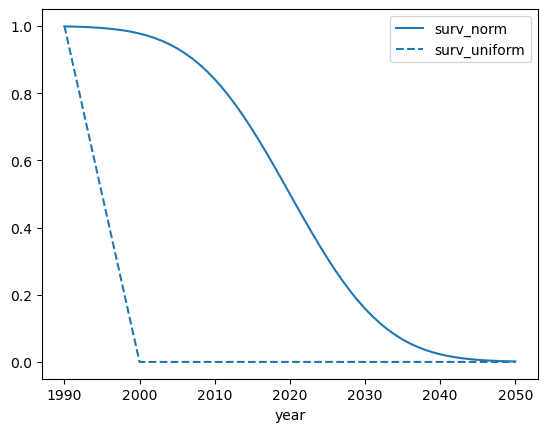

In [6]:
# Compare the survival curves
data[["surv_norm", "surv_uniform"]].plot(
    color=["C0", "C0"],
    style=["-", "--"],
)

<Axes: xlabel='year'>

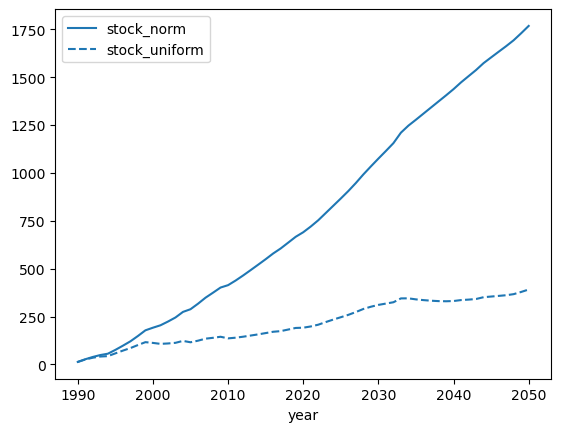

In [7]:
# Compare the evolution of the stocks over time
data[["stock_norm", "stock_uniform"]].plot(
    color=["C0", "C0"],
    style=["-", "--"],
)

The first model accumulates far more stocks than the second model, though the first few years are nearly identical


<Axes: xlabel='year'>

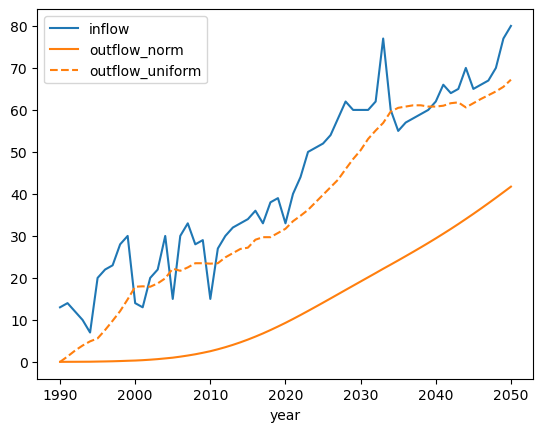

In [8]:
# Compare the evolution of the outflows over time
data[["inflow", "outflow_norm", "outflow_uniform"]].plot(
    color=["C0", "C1", "C1"],
    style=["-", "-", "--"],
)

The first model generates far less outflows than the second model, and the second model's outflows grow faster in the beginning and are more "jittery"


<Axes: xlabel='year'>

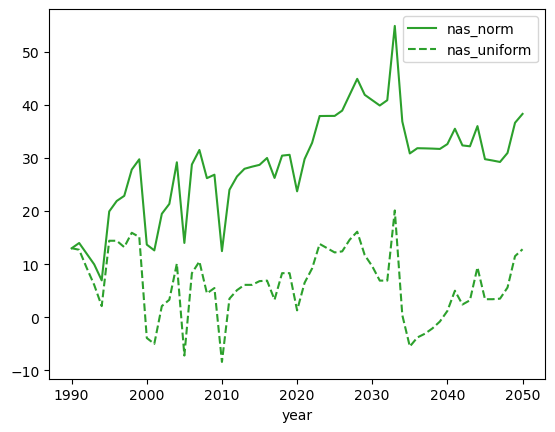

In [9]:
# And if you are curious about the net addition to stock
data[["nas_norm", "nas_uniform"]].plot(
    color=["C2", "C2"],
    style=["-", "--"],
)

<Axes: xlabel='year', ylabel='year'>

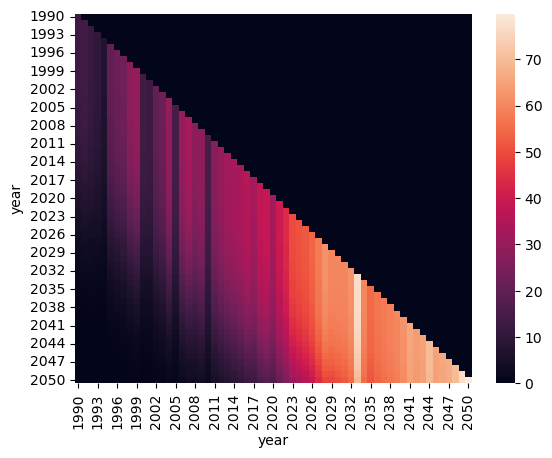

In [10]:
# visualize the cohort_surv_matrix matrix with a heatmap
sns.heatmap(cohort_surv_matrix, annot=False)

<Axes: xlabel='year', ylabel='year'>

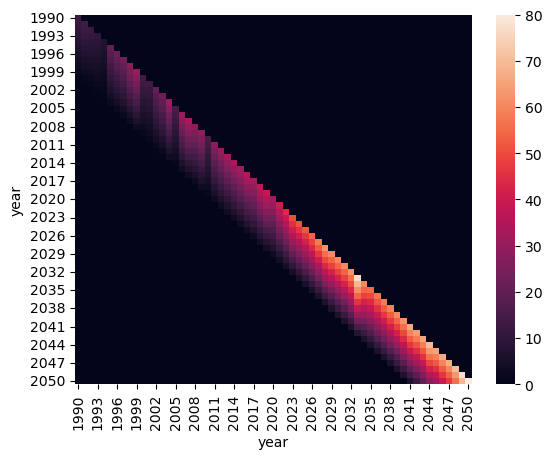

In [11]:
# visualize the cohort_surv_matrix_unif matrix with a heatmap
sns.heatmap(cohort_surv_matrix_unif, annot=False)

---


# Question 3

It turns out that funky furniture pieces hold up well as in-use stock for a period, but afterwards they start to break and rot. So it’s best to keep as many of them as possible in the stock for around 10 years, and then start getting rid of them. They should be mostly sold off after no later than 15 years after purchase.

- Use a Weibull distribution to create a curve that describes this, re-run the model and show the results.
- Shortly describe the differences in stocks and outflows between question 2 and question 3.

**Note:** You’ll need to change the default parameters of both the shape and scale of the Weibull to get it to approximate this description. It’s a bit of a trial and error to find the right combination of parameters, visualize them!


In [12]:
# Create the survival curve
# ! These parameters worked for us, but any values in these ranges would be ok
curve_surv_wb = weibull_min.sf(
    timesteps,
    c=15,  # controls the shape of the curve (skewness)
    loc=0,  # shifts the curve along the x-axis (starting point)
    scale=13,  # Stretches or compresses the curve along the x-axis (spread)
)

# create the survival curve matrix
curve_surv_matrix_wb = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Fill the survival curve matrix with the shifted survival curve
    curve_surv_matrix_wb.loc[time:time_max, time] = curve_surv_wb[0 : time_max - time]

# Define the input for the inflow-driven model
inflows = data["inflow"]

# Create the cohort_surv_matrix filled with zeros, and we populate it
cohort_surv_matrix_wb = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Scale the shifted survival curve with the inflow of the time-th year
    cohort_surv_matrix_wb.loc[:, time] = curve_surv_matrix_wb.loc[:, time] * inflows.iloc[time]

# Set index and columns to actual years instead of timesteps
cohort_surv_matrix_wb.index = years
cohort_surv_matrix_wb.columns = years

# Compute the stock, nas, and outflows
data["surv_weibull"] = curve_surv_wb
data["stock_weibull"] = cohort_surv_matrix_wb.sum(axis=1)
data["nas_weibull"] = np.diff(data["stock_weibull"], prepend=0)
data["outflow_weibull"] = data["inflow"] - data["nas_weibull"]

<Axes: xlabel='year'>

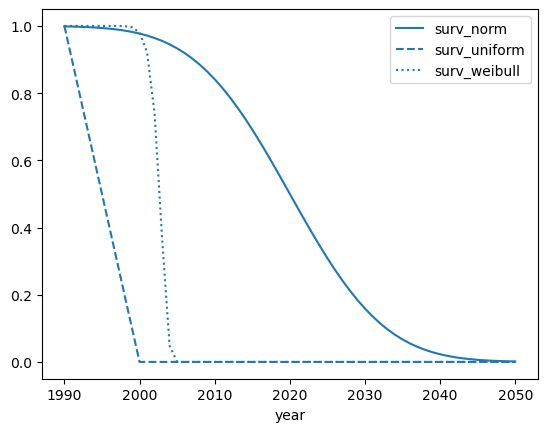

In [13]:
# Compare the survival curves
data[["surv_norm", "surv_uniform", "surv_weibull"]].plot(
    color=["C0", "C0", "C0"],
    style=["-", "--", ":"],
)

<Axes: xlabel='year'>

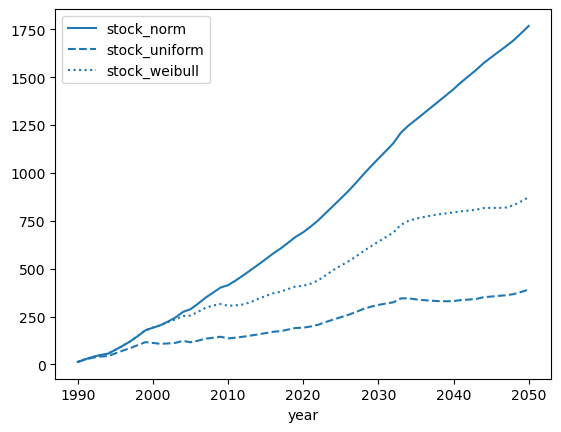

In [14]:
# Compare the evolution of the stocks over time
data[["stock_norm", "stock_uniform", "stock_weibull"]].plot(
    color=["C0", "C0", "C0"],
    style=["-", "--", ":"],
)

The Weibull model accumulates more stocks than the uniform dist. model but less than the normal dist. model. It diverges from the normal dist. stock only after about 12 years.


<Axes: xlabel='year'>

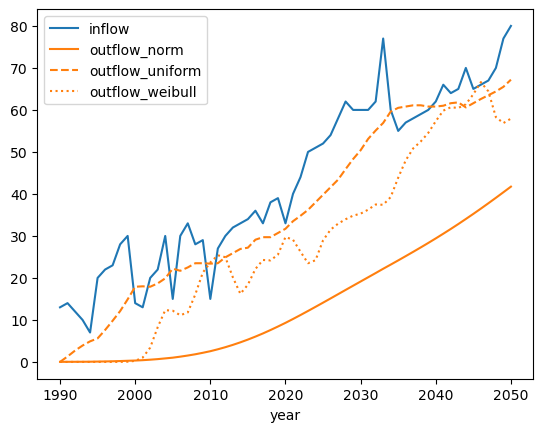

In [15]:
# Compare the evolution of the outflows over time
data[["inflow", "outflow_norm", "outflow_uniform", "outflow_weibull"]].plot(
    color=["C0", "C1", "C1", "C1"],
    style=["-", "-", "--", ":"],
)

The Weibull model's outflows fluctuate a lot but overall grow similarly to the uniform dist. model. The first 10 years have nearly identical outflows as in the normal dist. model.


<Axes: xlabel='year'>

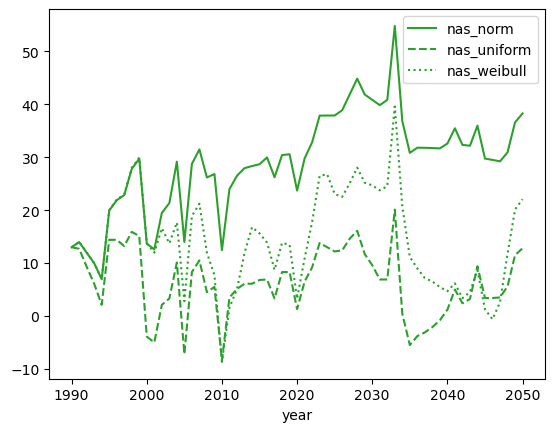

In [16]:
# And if you are curious about the net addition to stock
data[["nas_norm", "nas_uniform", "nas_weibull"]].plot(
    color=["C2", "C2", "C2"],
    style=["-", "--", ":"],
)

<Axes: xlabel='year', ylabel='year'>

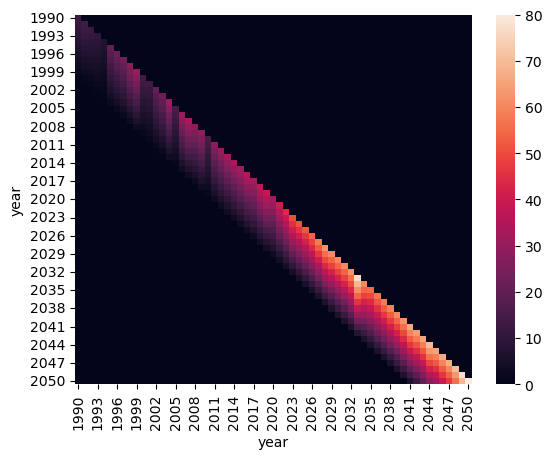

In [17]:
# visualize the cohort_surv_matrix matrix with a heatmap
sns.heatmap(cohort_surv_matrix_unif, annot=False)

<Axes: xlabel='year', ylabel='year'>

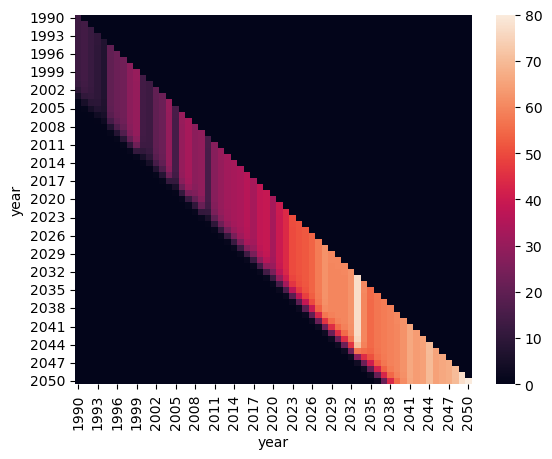

In [18]:
# visualize the cohort_surv_matrix_wb matrix with a heatmap
sns.heatmap(cohort_surv_matrix_wb, annot=False)

---


For the next 3 questions, use the python [stock-driven model](https://github.com/adrien-perello/MFA/blob/main/week_02/code/week_2_stock_driven.ipynb) with the ceramic plates **stock** data from `week_02/data_input/MFA_II_tutorial_II.xlsx`, on the `stock_driven` sheet.

In class, we used the same default **normal distribution survival curve** of mean=30 and sd=10 to describe the survival & outflow of the stock, and to quantify the required inflows needed to build up and maintain this stock.

We didn’t mention this in class, but the reason for this survival curve is that the owner of these plates has a cat at home, and the cat likes to knock things over. Especially things that break (recordings evidence here: https://www.youtube.com/watch?v=09CC-dYDNMQ).

So the plate collector has to buy (i.e. inflow) new plates to replace the ones that the cat breaks, and also buy new plates to expand her plate collection.


## Question 4

The ceramic plates collector is worried about running out of space at home. She thinks that she only has room for 503 plates.

- Change the input stock data from 2030-2050 to 503 plates, and rerun the model with the default normal distribution.
- Describe the changes to the inflows, outflows, and stocks compared to the default.


In [19]:
# Load input data
file_path = BASE_DIR / "data_input" / "MFA_II_tutorial_II.xlsx"
data = pd.read_excel(file_path, sheet_name="stock_driven")

# set the index to year
data = data.set_index(["year"])

# define useful variables
years = data.index
end_year = years[-1]
time_max = data.shape[0]
timesteps = np.arange(0, time_max)

## Original model


First let's run the original model


In [ ]:
# Create the survival curve
curve_surv = norm.sf(timesteps, loc=30, scale=10)

# create the survival curve matrix
curve_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Fill the survival curve matrix with the shifted survival curve
    curve_surv_matrix.loc[time:time_max, time] = curve_surv[0 : time_max - time]

# Define the input for the stock-driven model
stock = data["stock"]

# create inflow series and survival matrix filled with zeros and populate them
inflows = pd.Series(0, index=years, dtype=float)
cohort_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # we calculate the inflow of the time-th year
    inflows.iloc[time] = (
        stock.iloc[time] - cohort_surv_matrix.loc[time, : time - 1].sum()
    ) / curve_surv_matrix.loc[time, time]
    # and we scale the shifted survival curve with the inflow
    cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * inflows.iloc[time]

# set index and columns to years instead of timesteps
cohort_surv_matrix.index = years
cohort_surv_matrix.columns = years

# Compute nas, and outflows
data["inflow"] = inflows
data["nas"] = np.diff(data["stock"], prepend=0)
data["outflow"] = data["inflow"] - data["nas"]

## New model


now let's modify the stocks, which we will call Stock503, and rerun the code with Stock503


In [21]:
# Define the input for the stock-driven model
# ! This part is different from the original model
# first make a copy and we overwrite the years 2030-2050
stock_503 = data["stock"].copy()
stock_503.loc[2030:2050] = 503

# create inflow series and survival matrix filled with zeros and populate them
inflows_503 = pd.Series(0, index=years, dtype=float)
cohort_surv_matrix_503 = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # we calculate the inflow of the time-th year
    inflows_503.iloc[time] = (
        stock_503.iloc[time] - cohort_surv_matrix_503.loc[time, : time - 1].sum()
    ) / curve_surv_matrix.loc[time, time]
    # and we scale the shifted survival curve with the inflow
    cohort_surv_matrix_503.loc[:, time] = curve_surv_matrix.loc[:, time] * inflows_503.iloc[time]

# set index and columns to years instead of timesteps
cohort_surv_matrix_503.index = years
cohort_surv_matrix_503.columns = years

# Compute nas, and outflows
data["stock_503"] = stock_503
data["inflow_503"] = inflows_503
data["nas_503"] = np.diff(data["stock_503"], prepend=0)
data["outflow_503"] = data["inflow_503"] - data["nas_503"]

<Axes: xlabel='year'>

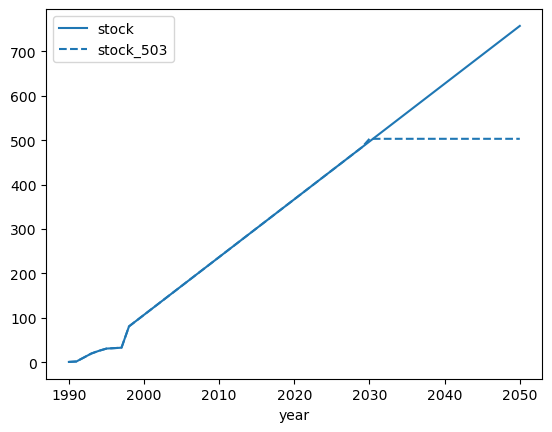

In [22]:
# Compare the evolution of the stocks over time
data[["stock", "stock_503"]].plot(
    color=["C0", "C0"],
    style=["-", "--"],
)

The stocks flatten after 2030, as we set it up


<Axes: xlabel='year'>

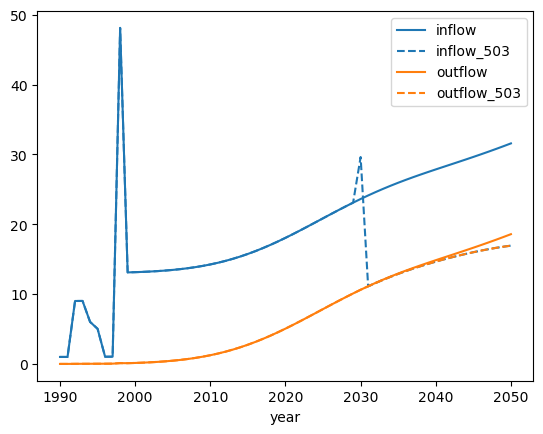

In [23]:
# Compare the evolution of the inflows and outflows over time
data[["inflow", "inflow_503", "outflow", "outflow_503"]].plot(
    color=["C0", "C0", "C1", "C1"],
    style=["-", "--", "-", "--"],
)

The 503 model's inflows drop in 2030, then start growing again but their growth seems to slow towards 2050.

The outflows only start diverging around 2035, slowing down their growth trend


<Axes: xlabel='year'>

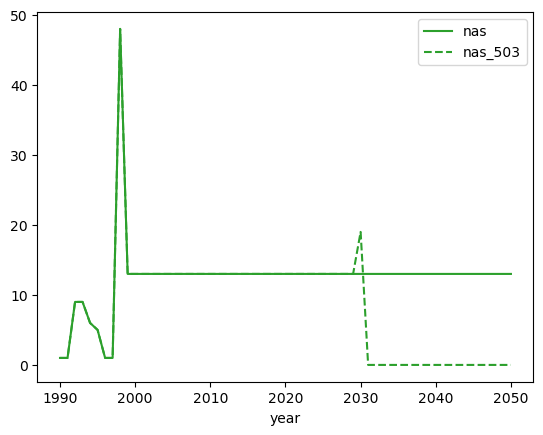

In [24]:
# And if you are curious about the net addition to stock
data[["nas", "nas_503"]].plot(
    color=["C2", "C2"],
    style=["-", "--"],
)

---


## Question 5

The ceramic plates collector is also wondering what would be the implications of giving away her cat to the neighbor (the furniture hoarder from the previous questions). In that case, the plates won’t break anymore until they are old: after exactly 45 years, they simply crumble to dust.

- Model this with the appropriate pair of survival curve and outflow curve, and compare the inflows, outflows, and stocks in such a case.


**ANSWER:**

This behavior is described by the **fixed lifetime survival curve** with a parameter value of 45 years.


In [25]:
# Create the survival curve
fixed_lifetime = 45
curve_surv_fixed = np.ones_like(timesteps)
curve_surv_fixed[fixed_lifetime:] = 0

# create the survival curve matrix
curve_surv_matrix_fixed = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Fill the survival curve matrix with the shifted survival curve
    curve_surv_matrix_fixed.loc[time:time_max, time] = curve_surv_fixed[0 : time_max - time]

# Define the input for the stock-driven model
stock = data["stock"]

# create inflow series and survival matrix filled with zeros and populate them
inflows_fixed = pd.Series(0, index=years, dtype=float)
cohort_surv_matrix_fixed = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # we calculate the inflow of the time-th year
    inflows_fixed.iloc[time] = (
        stock.iloc[time] - cohort_surv_matrix_fixed.loc[time, : time - 1].sum()
    ) / curve_surv_matrix_fixed.loc[time, time]
    # and we scale the shifted survival curve with the inflow
    cohort_surv_matrix_fixed.loc[:, time] = curve_surv_matrix_fixed.loc[:, time] * inflows_fixed.iloc[time]

# set index and columns to years instead of timesteps
cohort_surv_matrix_fixed.index = years
cohort_surv_matrix_fixed.columns = years

# Compute nas, and outflows
data["inflow_fixed"] = inflows_fixed
data["nas_fixed"] = np.diff(data["stock"], prepend=0)
data["outflow_fixed"] = data["inflow_fixed"] - data["nas_fixed"]

<Axes: xlabel='year'>

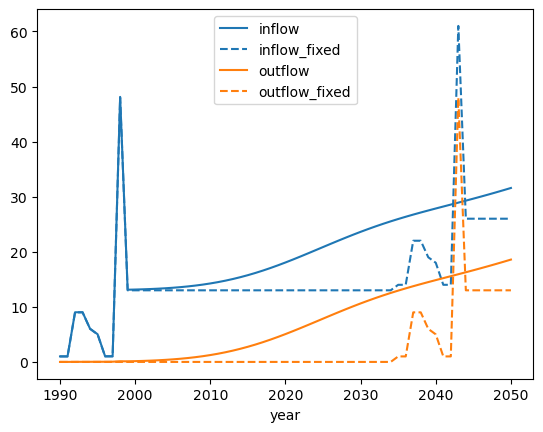

In [26]:
# Compare the evolution of the inflows and outflows over time
data[["inflow", "inflow_fixed", "outflow", "outflow_fixed"]].plot(
    color=["C0", "C0", "C1", "C1"],
    style=["-", "--", "-", "--"],
)

The stocks haven't changed because they are input data into the model.

The inflows are no longer a smooth growing curve, rather they are stable from 2000-2035 and then they mirror the original inflows, just higher.

The outflows are an exact mirror of the inflows, 45 years later.


<Axes: xlabel='year'>

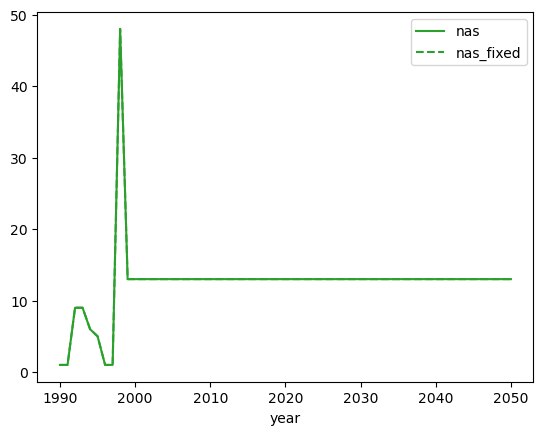

In [27]:
# And if you are curious about the net addition to stock
data[["nas", "nas_fixed"]].plot(
    color=["C2", "C2"],
    style=["-", "--"],
)

---


## Question 6

- In which of the previous two scenarios will the collector have more to buy more plates (i.e. more inflows): if she limits her stock to 503 from 2030 on, or if she keeps accumulating stocks as in the original data but gives away her cat?


**ANSWER:**


In [28]:
data["inflow_503"].sum()

np.float64(912.0560095792869)

If she limits her stock to 503 from 2030 on, she will buy a total of **912.06 plates** between 1990-2050


In [29]:
data["inflow_fixed"].sum()

np.float64(929.0)

If she keeps accumulating stocks but gives away her cat, she will buy a total of **929 plates** between 1990-2050


In [30]:
data["inflow"].sum()

np.float64(1174.9590392473758)

Just for comparison, in the original case she will buy a total of **1174.96 plates** between 1990-2050


---


Extra questions (Highly recommended to answer before our next class session, but your grade won’t be affected if you don’t submit these in time)


## (Optional) Question 7

- Show that the Python models and Excel models get the same results when you use the same data inputs, or describe any differences.


**ANSWER:**

They produce the same results for all intents and purposes, except for minuscule differences due to rounding errors and different approximation methods


---


## (Optional) Question 8

- Using the flow-driven model with input data of your choice, add python code to calculate the outflows divided by the stock (outflows/stocks) for every year. This is a useful measure of the % of the total stock that reaches the end-of-life in a given year.
- Does this measure fluctuate over time, or is it always the same %?
- Can you find a type of survival curve in which it’s always the same %, regardless of the amounts of flows and stocks?


**ANSWER:**

let's re-run the original code from question 2 (as an example)


In [31]:
# Load input data
file_path = BASE_DIR / "data_input" / "MFA_II_tutorial_II.xlsx"
data = pd.read_excel(file_path, sheet_name="inflow_driven")

# set the index to year
data = data.set_index(["year"])

# define useful variables
years = data.index
end_year = years[-1]
time_max = data.shape[0]
timesteps = np.arange(0, time_max)

# Create the survival curve
curve_surv = norm.sf(timesteps, loc=30, scale=10)

# create the survival curve matrix
curve_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Fill the survival curve matrix with the shifted survival curve
    curve_surv_matrix.loc[time:time_max, time] = curve_surv[0 : time_max - time]

# Define the input for the inflow-driven model
inflows = data["inflow"]

# Create the cohort_surv_matrix filled with zeros, and we populate it
cohort_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Scale the shifted survival curve with the inflow of the time-th year
    cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * inflows.iloc[time]

# Set index and columns to actual years instead of timesteps
cohort_surv_matrix.index = years
cohort_surv_matrix.columns = years

# Compute the stock, nas, and outflows
data["surv"] = curve_surv
data["stock"] = cohort_surv_matrix.sum(axis=1)
data["nas"] = np.diff(data["stock"], prepend=0)
data["outflow"] = data["inflow"] - data["nas"]

We now run this code snippet:


<Axes: xlabel='year'>

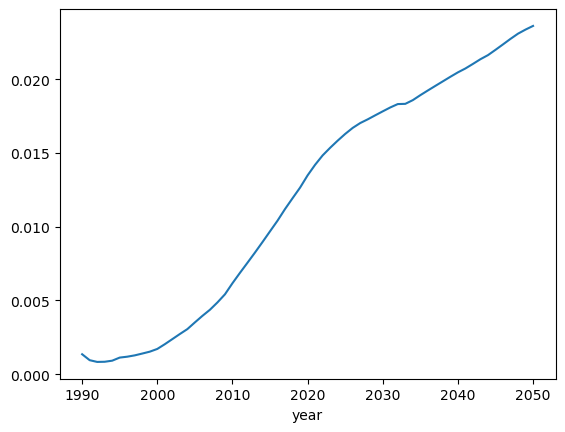

In [32]:
data["out_div_by_stock"] = data["outflow"] / data["stock"]
data["out_div_by_stock"].plot()

Clearly this ratio changes over time.


The **geometric survival curve** is supposed to be the only survival curve that keeps this ratio identical over time.

It's a special feature of this curve, and the ratio is equal to the **depreciation rate** parameter. However in practice it converges to that value and fluctuates around it, due to rounding errors and other technical issues (see below)


<Axes: xlabel='year'>

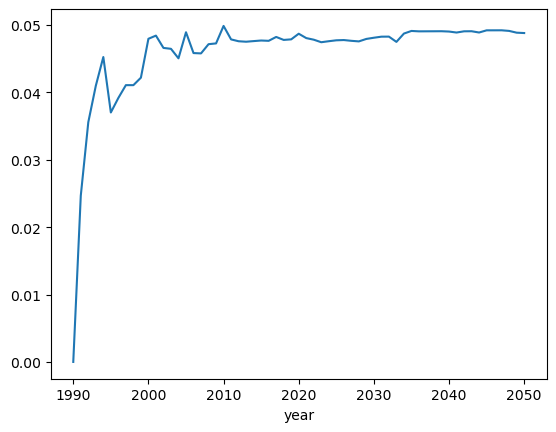

In [33]:
from scipy.stats import geom

# Geometrically distributed survival curve
curve_surv = geom.sf(
    timesteps,
    p=0.05,  # controls the depreciation rate
    loc=0,  # shifts the curve along the x-axis (starting point)
)

# create the survival curve matrix
curve_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Fill the survival curve matrix with the shifted survival curve
    curve_surv_matrix.loc[time:time_max, time] = curve_surv[0 : time_max - time]

# Define the input for the inflow-driven model
inflows = data["inflow"]

# Create the cohort_surv_matrix filled with zeros, and we populate it
cohort_surv_matrix = pd.DataFrame(0, index=timesteps, columns=timesteps, dtype=float)
for time in timesteps:
    # Scale the shifted survival curve with the inflow of the time-th year
    cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * inflows.iloc[time]

# Set index and columns to actual years instead of timesteps
cohort_surv_matrix.index = years
cohort_surv_matrix.columns = years

# Compute the stock, nas, and outflows
data["surv"] = curve_surv
data["stock"] = cohort_surv_matrix.sum(axis=1)
data["nas"] = np.diff(data["stock"], prepend=0)
data["outflow"] = data["inflow"] - data["nas"]

# Compute the outflow divided by stock ratio for the geometric survival curve
data["out_div_by_stock"] = data["outflow"] / data["stock"]
data["out_div_by_stock"].plot()